In [2]:
from tqdm import tqdm
import glob
import os
import datetime
import numpy as np
import pandas as pd

## Dev

In [12]:
# file_name = './F20240822162559.bin'
folder_path = "./optical/"
os.makedirs(folder_path,exist_ok=True)
files = glob.glob('./raw_data/*.bin')
files.sort()
file_name = files[-2]

print(file_name)
with open(file_name, 'rb') as f:
    packetData = f.read().split(b'\x1A\xCF\xFC\x1D')[1:]

mpduPackets = []
print('Number of Packets: ', len(packetData))
for packet in packetData:
    mpduPackets.append(packet[28:])

./raw_data/F20250109155526.bin
Number of Packets:  23995


In [13]:
len(packetData[0]), len(mpduPackets[0])

(1303, 1275)

In [14]:
len(mpduPackets[23025]), len(mpduPackets[23028]), len(mpduPackets[23030]), len(mpduPackets[23035])

(1275, 1275, 1275, 1275)

mpduPackets 24412*1275 (Npacket x mpdusize)
1275: 
    header: [:28]
        VCDU: [:2]
        PSC: [2:5]
        Idle: [6]
        MDPU: [6:28]
    image: [28:-160] , 1087, payload size
    data quality: [-160:], need to check with Hashimoto-san

In [10]:
imgData = bytes()
# headers = [[VCDU], [PSC], [IB]]
headers = [[], [], []]
desyncs = []
hk = []

for k, packet in enumerate(tqdm(mpduPackets)):
    
    if packet[:2] == b'\x55\x40':
        headers[0].append('IM')
        # imgData += packet[28:-160]
    elif packet[:2] == b'\x40\x3F':
        headers[0].append('HK')
        hk.append(packet.hex())
    else:
        headers[0].append('UnClassified')
    
    headers[1].append(int.from_bytes(packet[2:5], 'big'))
    headers[2].append(packet[6])

headerDF = pd.DataFrame(np.array(headers).T, columns=['VCDU', 'PSC', 'IB'])

# imgData = imgData.rstrip(b'\0')

print('Total Image Packets: ', headerDF[headerDF['VCDU'] == 'IM'].shape[0])
# print('Total images: ',len(imgData))
print('UnClassified Packets: ', headerDF[headerDF['VCDU'] == 'UnClassified'].shape[0])
print('Missed packet rate (missed/Image packet %): ', 
    (headerDF[headerDF['VCDU'] == 'UnClassified'].shape[0]/headerDF[headerDF['VCDU'] == 'IM'].shape[0])*100)

IM, HK = headerDF[headerDF['VCDU'] == 'IM']['PSC'].astype(int), headerDF[headerDF['VCDU'] == 'HK']['PSC'].astype(int)
IM_range = set(range(int(min(IM)), int(max(IM))+1))
HK_range = set(range(int(min(HK)), int(max(HK))+1))
missing_IM = IM_range - set(IM)
missing_HK = HK_range - set(HK)

print('Sequence number of Missing Image Packets: ', missing_IM)
print('Sequence number of Missing HK Packets: ', missing_HK)
print('real missed packets: ', len(missing_IM)+len(missing_HK))

# nfiles = len(glob.glob(os.path.join(folder_path, '*.bin')))
# dt_now = datetime.datetime.now()
# time_now = dt_now.strftime('%d_%H%M%S')
# with open(f'./optical/opt_frame_{nfiles}_{time_now}.bin', 'wb') as f:
#     f.write(imgData)

# print(desyncs)

100%|██████████| 24412/24412 [00:00<00:00, 1247898.86it/s]

Total Image Packets:  16621
UnClassified Packets:  6
Missed packet rate (missed/Image packet %):  0.03609891101618434
Sequence number of Missing Image Packets:  set()
Sequence number of Missing HK Packets:  set()
real missed packets:  0


In [77]:
len(HK_range), len(HK), min(HK), max(HK)

(7518, 7362, 620, 8137)

In [20]:
imgData = bytes()
i = 0
j=0
l=0
desyncs = []
hk = []
index = 1
fout = open('/home/amos/VERTECS/python_program/image_check/DQ_check/header_out_hex.txt','w')

for k, packet in enumerate(tqdm(mpduPackets)):
    
    if packet[:2] == b'\x55\x40':
        i += 1
        # index = int.from_bytes(packet[26:28],'big')
        # imgData += packet[28:-160]
    elif packet[:2] == b'\x40\x3F':
    # elif packet[:2] == b'\x51\xFF':
        hk.append(packet.hex())
        pass
    else:
        desyncs.append((k,index,packet[:2].hex()))
        j+=1
        
    fout.write(
        f'{packet[:2].hex()}, {packet[2:5].hex()}, {packet[6]}, {packet[6:28].hex()}\n'
    )
    
fout.close()

100%|██████████| 24412/24412 [00:00<00:00, 875281.88it/s]


In [11]:
imgData = bytes()
status = 'UK'
desyncs = []
hk = []
fout = open('/home/amos/VERTECS/python_program/image_check/DQ_check/header_out.txt','w')

for k, packet in enumerate(tqdm(mpduPackets)):
    
    if packet[:2] == b'\x55\x40':
        status = 'IM'
    elif packet[:2] == b'\x40\x3F':
        hk.append(packet.hex())
        status = 'HK'
        pass
    else:
        status = 'UnClassified'
        
    fout.write(
        f'{status}, {int.from_bytes(packet[2:5], 'big')}, {packet[6]}, {packet[6:28].hex()}, {packet[-160:].hex()}\n'
    )
    # fout.write(
    #     f'{status}, {int.from_bytes(packet[2:5], 'big')}, {packet[6]}, {packet[6:28].hex()}, {int.from_bytes(packet[-160:], 'big')}\n'
    # )
    
fout.close()

100%|██████████| 24412/24412 [00:00<00:00, 569270.94it/s]


In [9]:
print('\x40\x3F'.encode('utf-8').hex(), '\x55\x40'.encode('utf-8').hex())

403f 5540


In [14]:
int.from_bytes(b'\x55\x40')

21824

## Auto test

In [30]:
files = glob.glob('./raw_data/test_x-band/*.bin')
files += glob.glob('./raw_data/test_x-band/*/*.bin')
files.sort()
# files = files[:2]

for file_name in tqdm(files):

    with open(file_name, 'rb') as f:
        packetData = f.read().split(b'\x1A\xCF\xFC\x1D')[1:]
        
    fout_name = f'./DQ_check/{'/'.join(file_name.split('/')[2:])}'
    fout_name = fout_name.replace('.bin', '_header.txt')
    fout = open(fout_name, 'w')
        
    mpduPackets = []
    
    for packet in packetData:
        mpduPackets.append(packet[28:])
        
    imgData = bytes()
    headers = [[], [], [], []]
    desyncs = []
    hk = []

    for k, packet in enumerate(mpduPackets):
        
        if packet[:2] == b'\x55\x40':
            headers[0].append('IM')
            # imgData += packet[28:-160]
        elif packet[:2] == b'\x40\x3F':
            headers[0].append('HK')
            hk.append(packet.hex())
        else:
            headers[0].append('UnClassified')
        
        headers[1].append(int.from_bytes(packet[2:5], 'big'))
        headers[2].append(packet[6])
        headers[3].append(packet[-160:].hex())
        fout.write(
            f'{headers[0][-1]}, {headers[1][-1]}, {headers[2][-1]}, {headers[3][-1]}\n'
        )
    fout.write(f'Number of Packets: {len(packetData)}\n')
    fout.close()

    try:
        fout = open(fout_name, 'a')
        headerDF = pd.DataFrame(np.array(headers).T, columns=['VCDU', 'PSC', 'IB', 'Parity'])
        fout.write(f'Total Image Packets: {headerDF[headerDF['VCDU'] == 'IM'].shape[0]}\n')
        fout.write(f'UnClassified Packets: {headerDF[headerDF['VCDU'] == 'UnClassified'].shape[0]}\n')

        IM, HK = headerDF[headerDF['VCDU'] == 'IM']['PSC'].astype(int), headerDF[headerDF['VCDU'] == 'HK']['PSC'].astype(int)
        IM_range = set(range(0, 16620))
        max_HK = HK[HK < 10000].max()
        HK_range = set(range(int(min(HK)), int(max_HK)+1))
        missing_IM = IM_range - set(IM)
        missing_HK = HK_range - set(HK)

        fout.write(f'Sequence number of Missing Image Packets: {missing_IM}\n')
        fout.write(f'Number of Missing Image Packets: {len(missing_IM)}\n')
        fout.write(f'Sequence number of Missing HK Packets: {missing_HK}\n')
        fout.write(f'Number of Missing HK Packets: {len(missing_HK)}\n')
        fout.write(f'Total missing packets: {len(missing_IM)+len(missing_HK)}\n')
        fout.write(f'Missed image rate (missing image/Image packet %): {(len(missing_IM)/16621)*100}\n')
        fout.close()
    
    except Exception as e:
        print(f'Error in {file_name}: {e}')


 27%|██▋       | 24/88 [00:02<00:03, 18.50it/s]

Error in ./raw_data/test_x-band/2nd_-20°C/F20250109171419.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/2nd_-20°C/F20250109171520.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/2nd_-20°C/F20250109171537.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/2nd_-20°C/F20250109171605.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/2nd_-20°C/F20250109171711.bin: min() iterable argument is empty


 85%|████████▌ | 75/88 [00:08<00:00, 18.45it/s]

Error in ./raw_data/test_x-band/Before_TVT/F20250107193448.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/Before_TVT/F20250107193641.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/Before_TVT/F20250107194042.bin: min() iterable argument is empty


 94%|█████████▍| 83/88 [00:08<00:00, 15.41it/s]

Error in ./raw_data/test_x-band/C20250110163605.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/C20250110164341.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/C20250110164457.bin: min() iterable argument is empty
Error in ./raw_data/test_x-band/F20250120132129.bin: min() iterable argument is empty


100%|██████████| 88/88 [00:09<00:00,  9.64it/s]

Error in ./raw_data/test_x-band/F20250127155842.bin: min() iterable argument is empty


### summarize out

In [21]:
files = glob.glob('./DQ_check/test_x-band/*.txt')
files += glob.glob('./DQ_check/test_x-band/*/*.txt')
files.sort()

N_packets = []
N_IM_packets = []
N_IM_missing = []
N_HK_missing = []
folder_path = []
filename = []

for file_name in tqdm(files):
    
    with open(file_name, 'r') as f:
        
        Out = f.readlines()
        if len(Out) < 10:
            print(f'{file_name} is empty')
            continue
        else:
            out = Out[-9:]
    
    try:
        N_packets.append(int(out[0].split(': ')[1].strip()))
        N_IM_packets.append(int(out[1].split(': ')[1].strip()))
        N_IM_missing.append(int(out[4].split(': ')[1].strip()))
        N_HK_missing.append(int(out[6].split(': ')[1].strip()))
        folder_path.append('/'.join(file_name.split('/')[2:-1]))
        filename.append(file_name.split('/')[-1])
    except Exception as e:
        print(f'Error in {file_name}: {e}')
        continue
    
df = pd.DataFrame({
    'N_packets': N_packets,
    'N_IM_packets': N_IM_packets,
    'N_IM_missing': N_IM_missing,
    'N_HK_missing': N_HK_missing,
    'folder_path': folder_path,
    'filename': filename
})

df.to_csv('./DQ_check/summary.csv', index=False)

 42%|████▏     | 37/88 [00:00<00:00, 115.67it/s]

./DQ_check/test_x-band/2nd_-20°C/F20250109171419_header.txt is empty
./DQ_check/test_x-band/2nd_-20°C/F20250109171520_header.txt is empty
./DQ_check/test_x-band/2nd_-20°C/F20250109171537_header.txt is empty
./DQ_check/test_x-band/2nd_-20°C/F20250109171605_header.txt is empty
./DQ_check/test_x-band/2nd_-20°C/F20250109171711_header.txt is empty


100%|██████████| 88/88 [00:00<00:00, 123.05it/s]

Error in ./DQ_check/test_x-band/Before_TVT/F20250107193448_header.txt: list index out of range
./DQ_check/test_x-band/Before_TVT/F20250107193641_header.txt is empty
./DQ_check/test_x-band/Before_TVT/F20250107194042_header.txt is empty
./DQ_check/test_x-band/C20250110163605_header.txt is empty
./DQ_check/test_x-band/C20250110164341_header.txt is empty
./DQ_check/test_x-band/C20250110164457_header.txt is empty
./DQ_check/test_x-band/F20250120132129_header.txt is empty
./DQ_check/test_x-band/F20250127155842_header.txt is empty


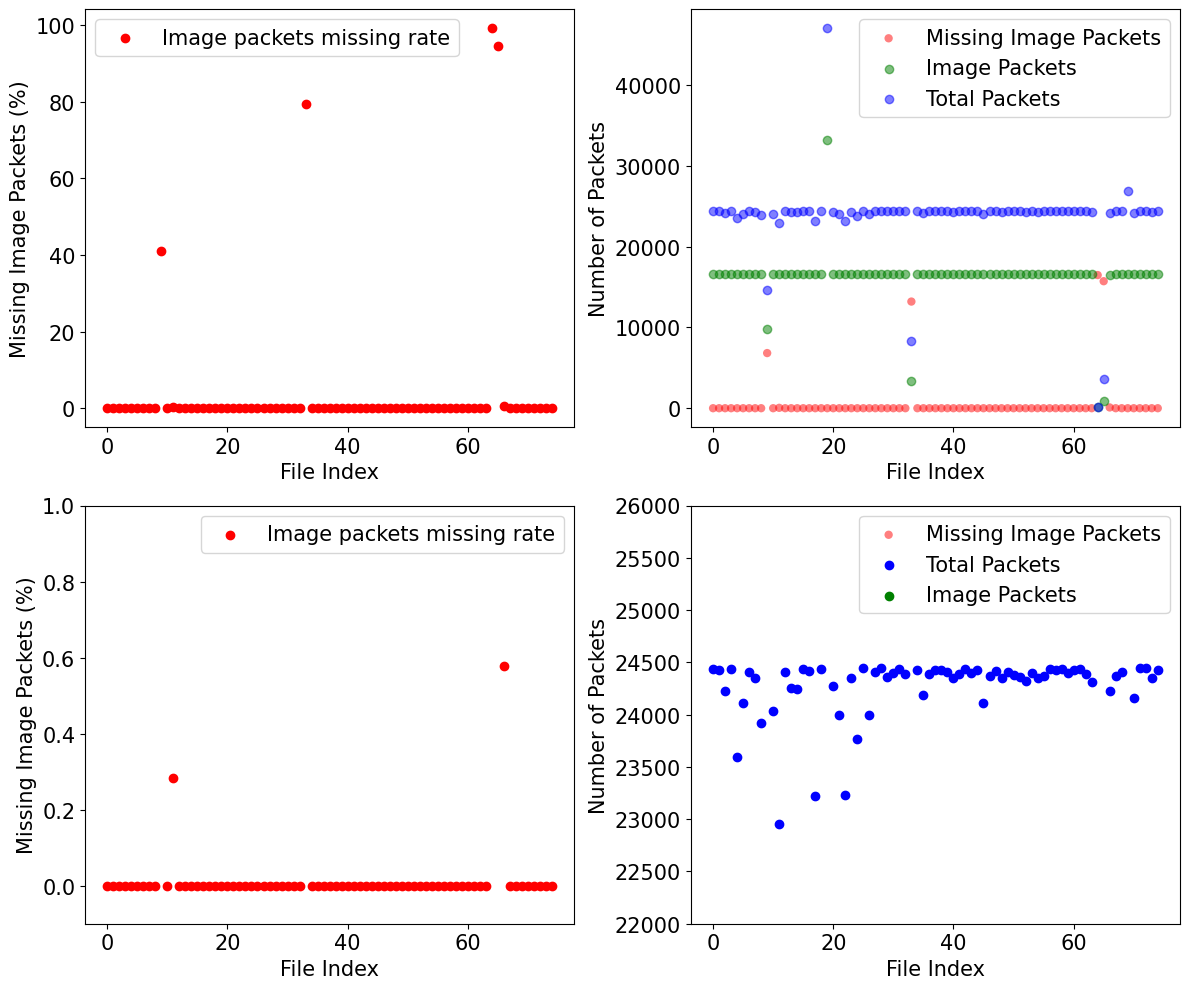

In [44]:
data = pd.read_csv('./DQ_check/summary.csv')

data['IM_missing_rate'] = (data['N_IM_missing']/16621)*100

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

N = data.shape[0]
ind = np.arange(N)

ax = axs[0, 0]
ax.scatter(ind, data['IM_missing_rate'], color='r', label='Image packets missing rate')
ax.set_ylabel('Missing Image Packets (%)', fontsize=15)

ax = axs[0, 1]
ax.scatter(ind, data['N_IM_missing'], color='r', edgecolors='None', alpha=0.5, label='Missing Image Packets')
ax.scatter(ind, data['N_IM_packets'], color='g', alpha=0.5, label='Image Packets')
ax.scatter(ind, data['N_packets'], color='b', alpha=0.5, label='Total Packets')
ax.set_ylabel('Number of Packets', fontsize=15)

ax = axs[1, 0]
ax.scatter(ind, data['IM_missing_rate'], color='r', label='Image packets missing rate')
ax.set_ylabel('Missing Image Packets (%)', fontsize=15)
ax.set_ylim(-0.1, 1)

ax = axs[1, 1]
ax.scatter(ind, data['N_IM_missing'], color='r', edgecolors='None', alpha=0.5, label='Missing Image Packets')
ax.scatter(ind, data['N_packets'], color='b', label='Total Packets')
ax.scatter(ind, data['N_IM_packets'], color='g', label='Image Packets')
ax.set_ylabel('Number of Packets', fontsize=15)
ax.set_ylim(22000, 26000)

for ax in axs.flat:
    ax.set_xlabel('File Index', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

## origin

In [66]:
imgData = bytes()
i = 0
j=0
l=0
desyncs = []
hk = []
index = 1

for k, packet in enumerate(tqdm(mpduPackets)):
    
    if packet[:2] == b'\x55\x40':
        i += 1
        index = int.from_bytes(packet[26:28],'big')
        imgData += packet[28:-160]
    elif packet[:2] == b'\x40\x3F':
    # elif packet[:2] == b'\x51\xFF':
        hk.append(packet.hex())
        pass
    else:
        desyncs.append((k,index,packet[:2].hex()))
        j+=1

avg = 0
imgData = imgData.rstrip(b'\0')

print('Total Image Packets: ', i)
print('Total images: ',len(imgData))
print('Missed Packets: ', j)
print('Missed packet rate (packet/1000): ', (j/i)*1000)


nfiles = len(glob.glob(os.path.join(folder_path, '*.bin')))
dt_now = datetime.datetime.now()
time_now = dt_now.strftime('%d_%H%M%S')
with open(f'./optical/opt_frame_{nfiles}_{time_now}.bin', 'wb') as f:
    f.write(imgData)

print(desyncs)
print(hk[20])

100%|██████████| 24412/24412 [00:17<00:00, 1418.91it/s] 

Total Image Packets:  16621
Total images:  18066048
Missed Packets:  6
Missed packet rate (packet/1000):  0.36098911016184343
[(0, 1, '39aa'), (1, 1, '736c'), (24408, 0, '3bd1'), (24409, 0, 'c190'), (24410, 0, '97d2'), (24411, 0, 'f54a')]
403f0001750007fe0d6606fc02bf0f3e00040bd4087f087f0000000024ff0105113250c80f000000e12312010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [63]:
len(hk)

7785